In [1]:
import arviz as az
import pandas as pd
import seaborn as sns
import os.path as op
import numpy as np

from bauer.utils.math import softplus_np
import matplotlib.pyplot as plt
from bauer.utils.math import softplus_np

from tms_risk.cogmodels.fit_model import build_model, get_data
from tms_risk.cogmodels.utils import plot_ppc

stimulation_palette = sns.color_palette()[2:4]
stimulation_order = ['Vertex', 'IPS']


bids_folder  = '/data/ds-tmsrisk'

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
def get_info(model_label, bids_folder='/data/ds-tmsrisk'):
    df = get_data(bids_folder, model_label)
    model = build_model(model_label, df)
    model.build_estimation_model()
    idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-{model_label}_trace.netcdf'))


    return df, model, idata

def get_pars(idata, group=True):
    traces = {}

    pars_vertex = []
    pars_ips = []

    keys = ['perceptual_noise_sd', 'memory_noise_sd', 'n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_mu', 'risky_prior_std', 'safe_prior_mu', 'safe_prior_std', 'prior_mu', 'prior_std']

    for key in keys:

        if group:
            key_ = key+'_mu'
        else:
            key_ = key
        
        if key_ in idata.posterior.keys():
            print(key_)

            traces[key] = idata.posterior[f'{key_}'].to_dataframe()

            ips_values = traces[key].xs('Intercept', 0, f'{key}_regressors')


            if 'stimulation_condition[T.vertex]' in traces[key].index.get_level_values(f'{key}_regressors'):
                vertex_values = ips_values + traces[key].xs('stimulation_condition[T.vertex]', 0, f'{key}_regressors')
            else:
                vertex_values = ips_values

            if (key in ['n1_evidence_sd', 'n2_evidence_sd']) and 'evidence_sd' in idata.posterior.keys():
                if group:
                    key__ = 'evidence_sd_mu'
                else:
                    key__ = 'evidence_sd'
                
                print('yo')
                ips_values += idata.posterior[key__].to_dataframe().xs('stimulation_condition[ips]', 0, f'evidence_sd_regressors').values
                vertex_values += idata.posterior[key__].to_dataframe().xs('stimulation_condition[vertex]', 0, f'evidence_sd_regressors').values


            if key in ['perceptual_noise_sd', 'memory_noise_sd', 'n1_evidence_sd', 'n2_evidence_sd', 'risky_prior_std', 'safe_prior_std']:
                ips_values = softplus_np(ips_values)
                vertex_values = softplus_np(vertex_values)

            pars_ips.append(ips_values)
            pars_vertex.append(vertex_values)


    pars_ips = pd.concat(pars_ips, axis=1)
    pars_vertex = pd.concat(pars_vertex, axis=1)

    pars = pd.concat((pars_ips, pars_vertex), keys=['IPS', 'Vertex'], names=['stimulation condition'])
    pars.columns.name = 'parameter'
    pars = pars.stack().to_frame('value')

    return pars


def plot_pars(pars, df, ):
    g = sns.FacetGrid(pars.reset_index(), col='parameter', sharey=False, col_wrap=3)

    g.map(sns.violinplot, 'stimulation condition', 'value', fill=True, palette=stimulation_palette, col_wrap=3, order=stimulation_order)
    g.set_titles('{col_name}')


    if len(g.axes.flat) == 6:
        g.axes.flat[2].axhline(np.log(df['n_risky'].mean()), color='k', linestyle='--')
        g.axes.flat[3].axhline(np.log(df['n_risky'].std()), color='k', linestyle='--')
        g.axes.flat[4].axhline(np.log(df['n_safe'].mean()), color='k', linestyle='--')
        g.axes.flat[5].axhline(np.log(df['n_safe'].std()), color='k', linestyle='--')

    return g


def plot_pars_diff(pars):
    tmp = pars.unstack('stimulation condition')['value']
    tmp = tmp['IPS'] - tmp['Vertex']
    g = sns.FacetGrid(tmp.to_frame('diff').reset_index(), col='parameter', col_wrap=3, sharex=False, sharey=False)

    g.map(sns.kdeplot, 'diff', fill=True, color='k')

    g.map(lambda *args, **kwargs: plt.axvline(0.0, c='k', ls='--'))

    g.set_titles('{col_name}')

    for ax, par in zip(g.axes.flat, g.col_names):
        p = (tmp.xs(par, 0, 'parameter') < 0.0).mean()
        
        if p != 0.0:
            ax.text(0.7, 0.8, f'p={p:0.3f}',
            horizontalalignment='left',
            fontsize=10,
            verticalalignment='center',
            transform = ax.transAxes)

    return g


def get_ppc(model, idata, df):
    model.build_estimation_model()
    ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=df)

    ix_risky_first = ppc.index.get_level_values('risky_first')
    ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

    return ppc

def plot_identity_line(*args, **kwargs):

    ax = plt.gca()
    xlim, ylim = ax.get_xlim(), ax.get_ylim()

    x0 = (xlim[0] + ylim[0]) / 2.
    x1 = (xlim[1] + ylim[1]) / 2.

    plt.plot([x0, x1], [x0, x1], c='k', ls='--')

def plot_scatter_with_errors(data, xlabel='Vertex', ylabel='IPS', **kwargs):

    x = data[('mean', xlabel)]
    y = data[('mean', ylabel)] 

    xerr_min = x - data['ci_min', xlabel]
    xerr_max = data['ci_max', xlabel] - x

    yerr_min = y - data['ci_min', ylabel]
    yerr_max = data['ci_max', ylabel] - y


    plt.errorbar(x, y, [yerr_min, yerr_max], [xerr_min, xerr_max], fmt='.', markersize=0, alpha=0.5, **kwargs)
    plt.scatter(data[('mean', xlabel)], data[('mean', ylabel)], marker='.', s=50, **kwargs)


def plot_individual_condition_difference(subject_pars):
    mean_pars = subject_pars.groupby(['stimulation condition', 'subject', 'parameter'])['value'].mean().to_frame('mean')
    ci_pars = subject_pars.groupby(['stimulation condition', 'subject', 'parameter'])['value'].apply(lambda x: pd.Series(az.hdi(x.values.ravel(), .95), index=pd.Index(['ci_min', 'ci_max']))).to_frame('value').unstack(-1)['value']

    par_stats = mean_pars.join(ci_pars)


    g = sns.FacetGrid(par_stats.unstack(['stimulation condition']).reset_index(), col='parameter', col_wrap=3, sharex=False, sharey=False)

    g.map_dataframe(plot_scatter_with_errors, color='k')
    g.map(plot_identity_line)
    g.set_titles('{col_name}')
    # g.set(xlabel='Vertex', ylabel='IPS')
    g.set_xlabels('Vertex')
    g.set_ylabels('IPS')

    return g

In [6]:
def process_model(model_label):
    df, model, idata = get_info(model_label)
    pars = get_pars(idata)

    g = plot_pars(pars, df)
    g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars.pdf'))

    g = plot_pars_diff(pars)
    g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars_diff.pdf'))

    subject_pars = get_pars(idata, group=False)

    plot_individual_condition_difference(subject_pars)

    plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars_before_after.pdf'))

    ppc = get_ppc(model, idata, df)

    for plot_type in [5,6,7]:
        plot_ppc(df, ppc, plot_type=plot_type, level='group')
        plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_ppc{plot_type}.pdf'))
    

# Model 1

In [36]:
model_label = '1'
df, model, idata = get_info(model_label)
pars = get_pars(idata)

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


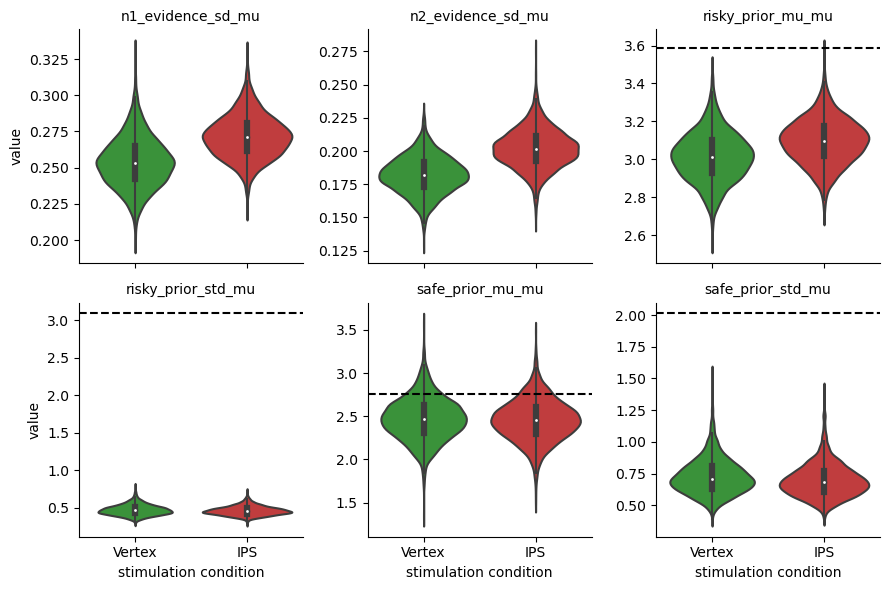

In [37]:
g = plot_pars(pars, df)
g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars.pdf'))

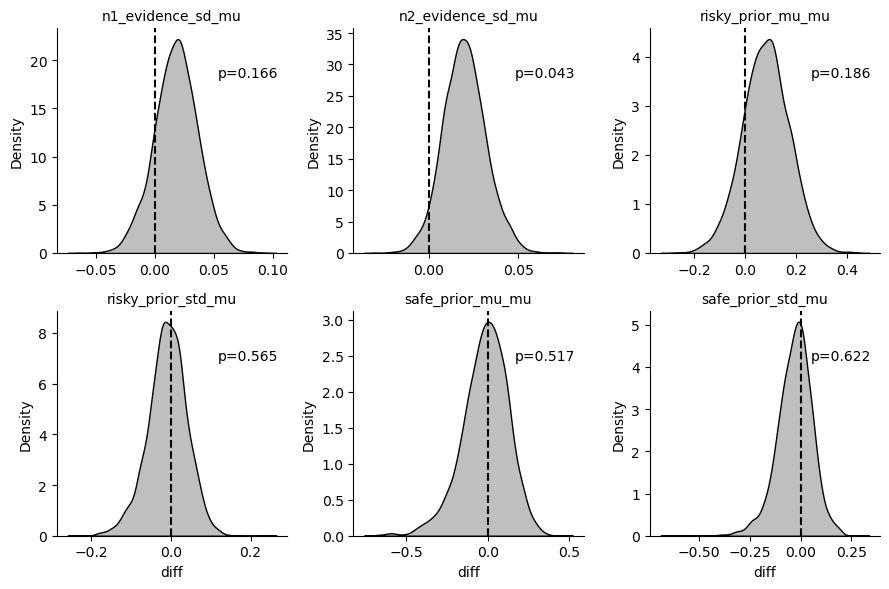

In [38]:
plot_pars_diff(pars)
g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars_diff.pdf'))

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_84534/3789290814.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ips_sd)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_84534/3789290814.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vertex_sd)


<Axes: ylabel='Density'>

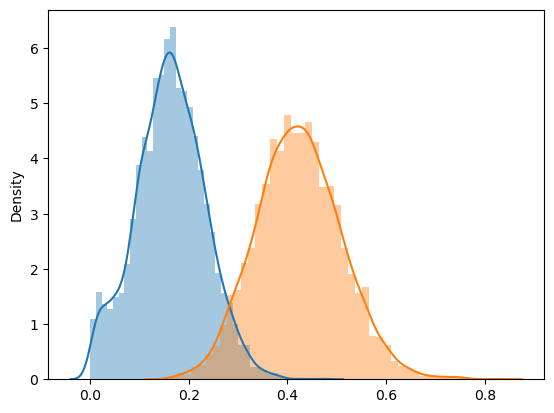

In [39]:
ips_sd = idata.posterior['n1_evidence_sd_sd'].to_dataframe().xs('Intercept', 0, -1)
vertex_sd = idata.posterior['n1_evidence_sd_sd'].to_dataframe().xs('Intercept', 0, -1) + idata.posterior['n1_evidence_sd_sd'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1)

sns.distplot(ips_sd)
sns.distplot(vertex_sd)

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_84534/546978285.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ips_sd)
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_84534/546978285.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(vertex_sd)


<Axes: ylabel='Density'>

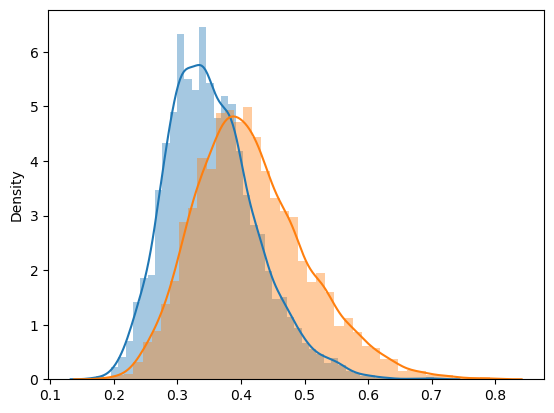

In [40]:
ips_sd = idata.posterior['n2_evidence_sd_sd'].to_dataframe().xs('Intercept', 0, -1)
vertex_sd = idata.posterior['n2_evidence_sd_sd'].to_dataframe().xs('Intercept', 0, -1) + idata.posterior['n2_evidence_sd_sd'].to_dataframe().xs('stimulation_condition[T.vertex]', 0, -1)

sns.distplot(ips_sd)
sns.distplot(vertex_sd)

In [41]:
subject_pars = get_pars(idata, group=False)

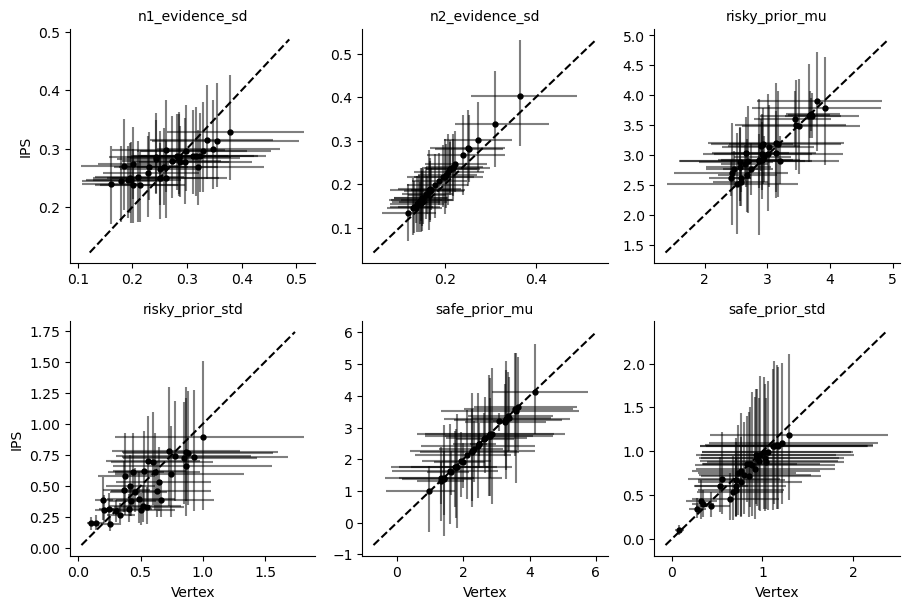

In [42]:
plot_individual_condition_difference(subject_pars)

plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars_before_after.pdf'))

### PPC

In [43]:
model.build_estimation_model()
ppc = model.ppc(trace=idata.sel(draw=slice(None, None, 10)), data=df)

ix_risky_first = ppc.index.get_level_values('risky_first')
ppc.loc[ix_risky_first] = 1- ppc.loc[ix_risky_first]

Sampling: [ll_bernoulli]


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

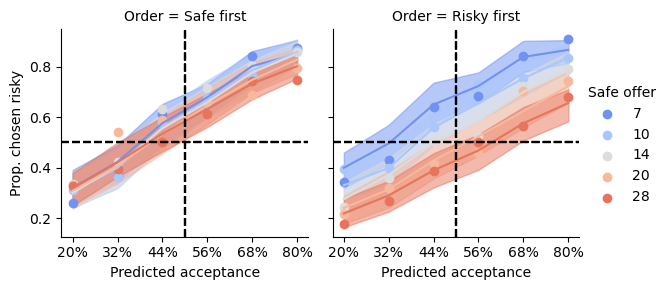

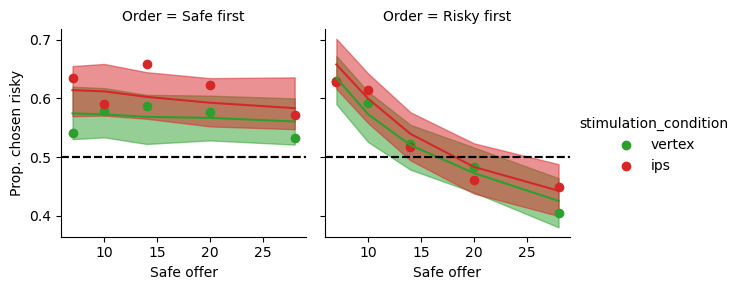

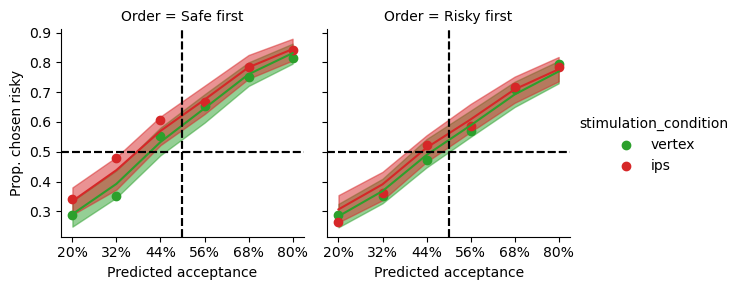

In [44]:
for plot_type in [5,6,7]:
    plot_ppc(df, ppc, plot_type=plot_type, level='group')
    plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-1_ppc{plot_type}.pdf'))

# Model 1c

In [20]:
model_label = '1c'
df, model, idata = get_info(model_label)
pars = get_pars(idata)

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


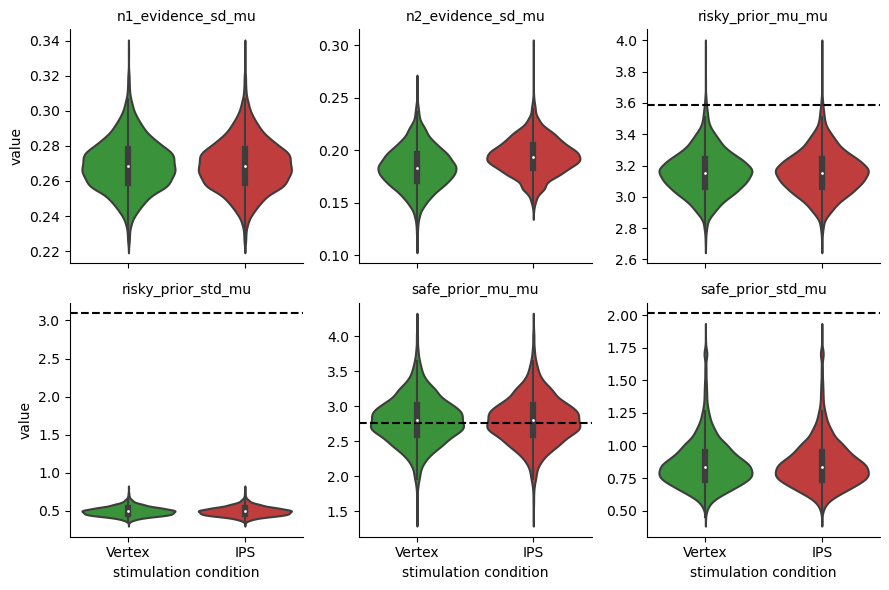

In [21]:
g = plot_pars(pars, df)
g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars.pdf'))

/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserW

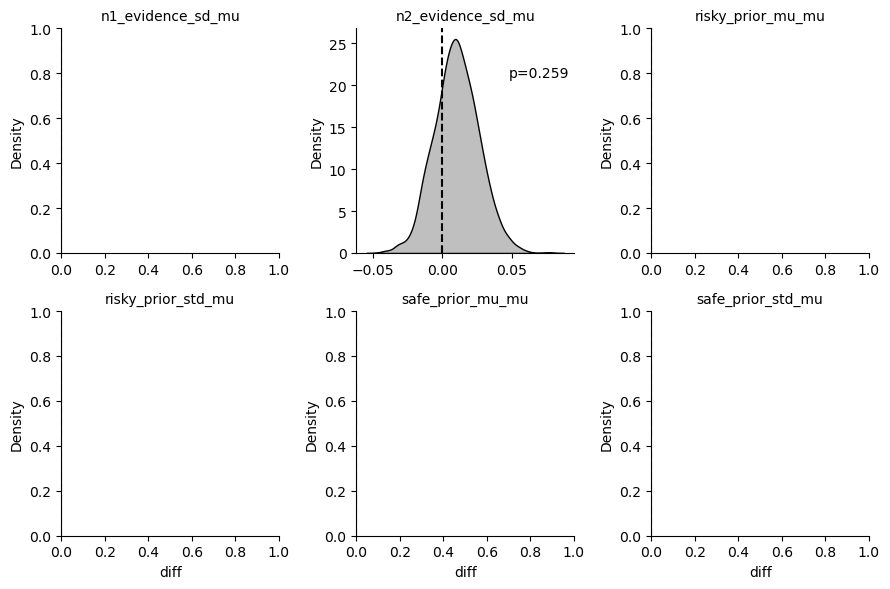

In [22]:
g = plot_pars_diff(pars)
g.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars_diff.pdf'))

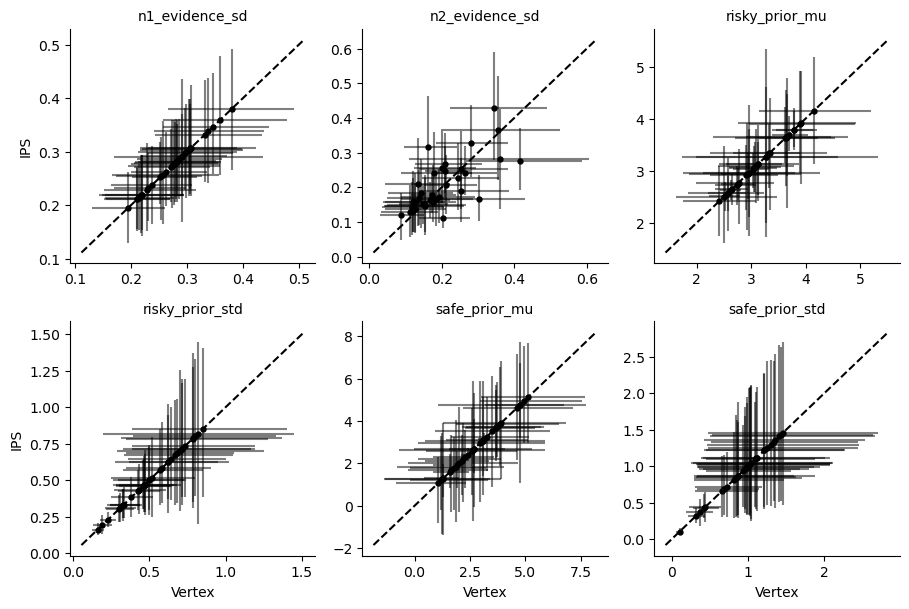

In [26]:
subject_pars = get_pars(idata, group=False)
plot_individual_condition_difference(subject_pars)
plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_pars_before_after.pdf'))

## PPC

In [29]:
ppc

Sampling: [ll_bernoulli]


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

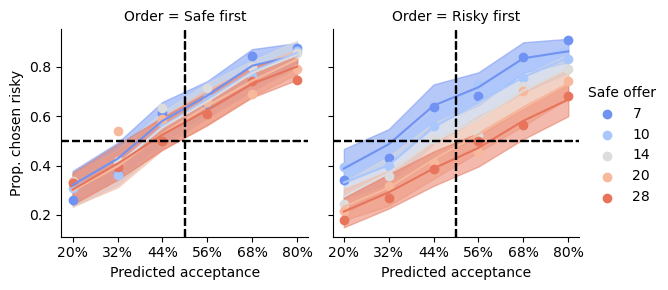

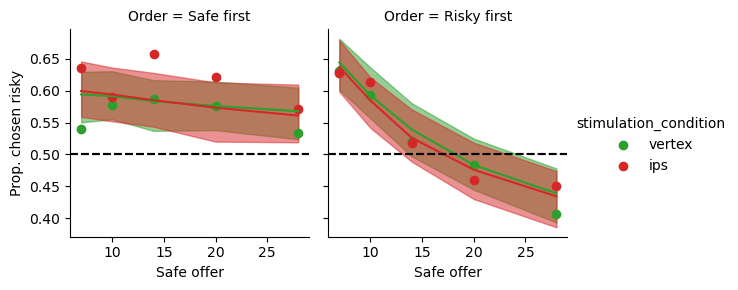

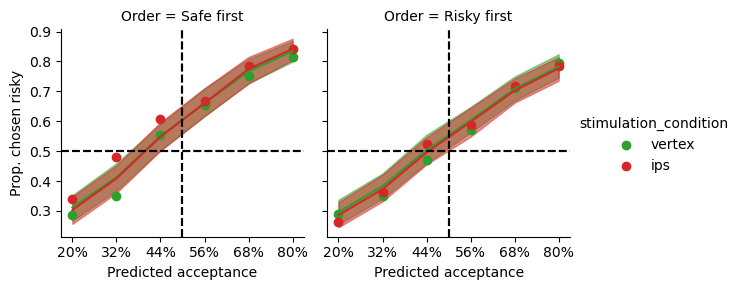

In [31]:
ppc = get_ppc(model, idata)

for plot_type in [5,6,7]:
    plot_ppc(df, ppc, plot_type=plot_type, level='group')
    plt.savefig(op.join(bids_folder, 'derivatives', 'figures', f'model-{model_label}_ppc{plot_type}.pdf'))

# Model 6a

In [4]:
process_model('6a')

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition
yo
***Warning, estimating evidence_sd for both first and second option, but (some) regressors affect both equally (via `evidence_sd`)***


KeyError: 'stimulation_condition[T.ips]'

# Model 6b

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition
yo
***Warning, estimating evidence_sd for both first and second option, but (some) regressors affect both equally (via `evidence_sd`)***
n1_evidence_sd_mu
yo
n2_evidence_sd_mu
yo
risky_prior_mu_mu
risky_prior_std_mu
safe_prior_mu_mu
safe_prior_std_mu


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserW

n1_evidence_sd
yo
n2_evidence_sd
yo
risky_prior_mu
risky_prior_std
safe_prior_mu
safe_prior_std
***Warning, estimating evidence_sd for both first and second option, but (some) regressors affect both equally (via `evidence_sd`)***


Sampling: [ll_bernoulli]


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

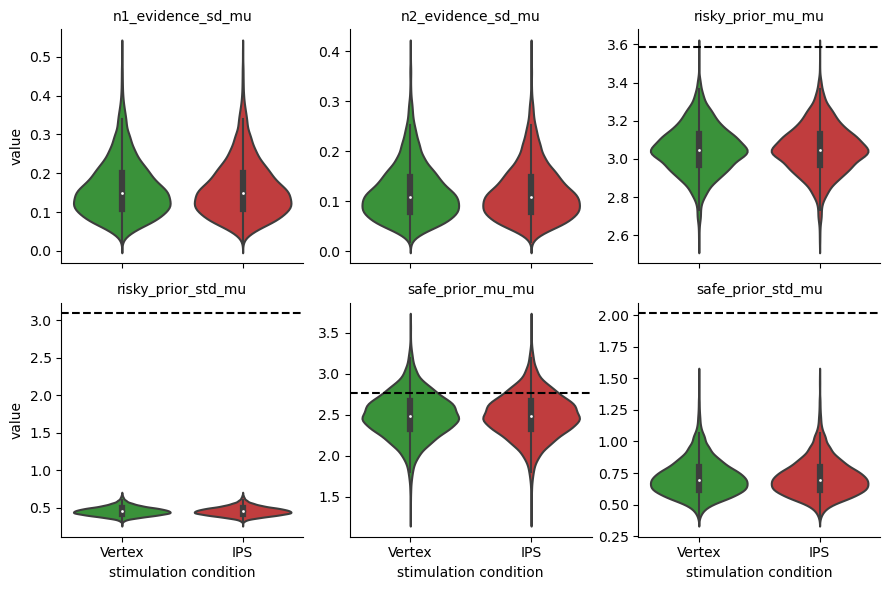

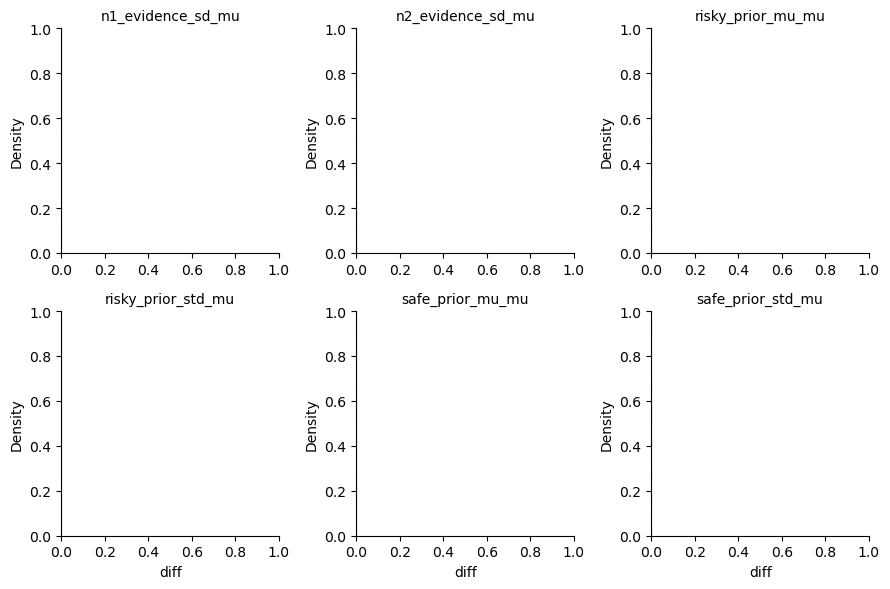

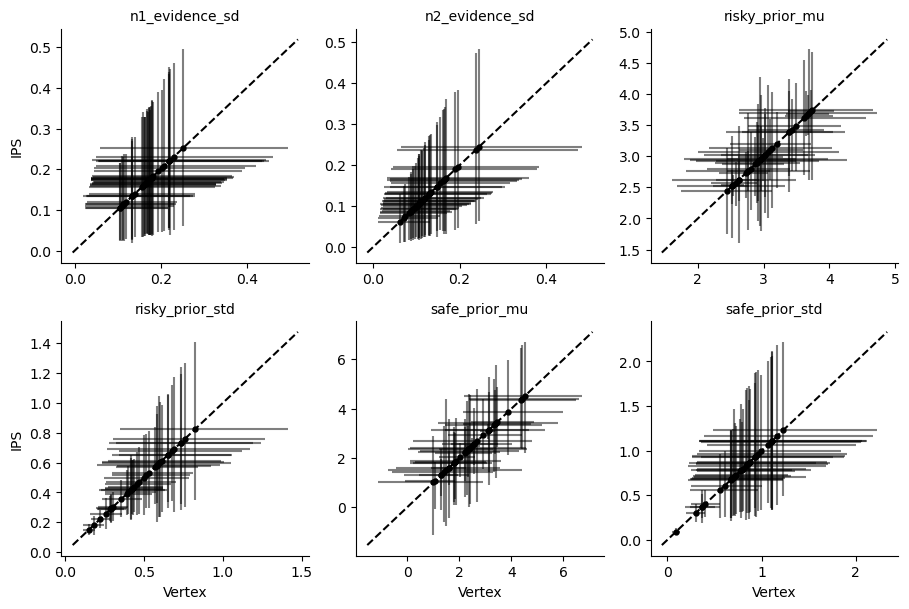

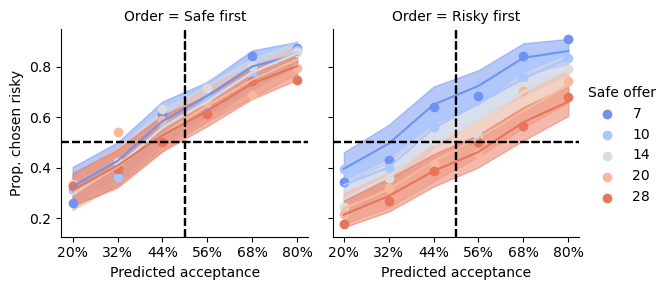

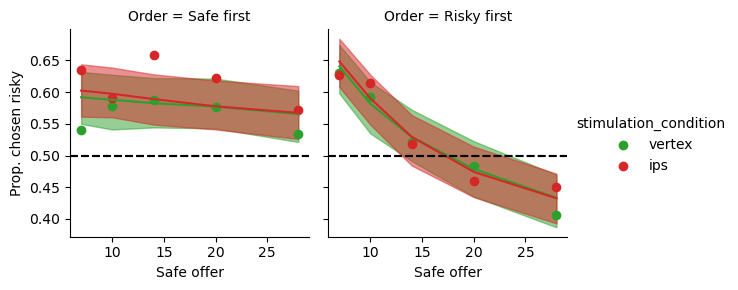

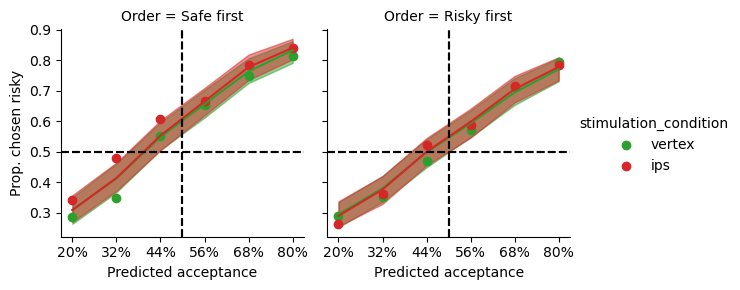

In [7]:
process_model('6b')

# Model 5

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


Sampling: [ll_bernoulli]


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

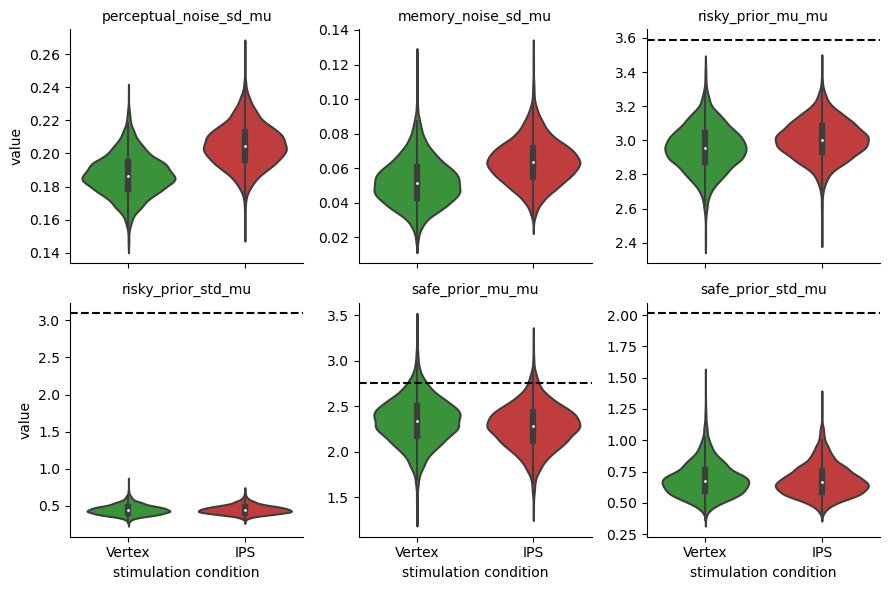

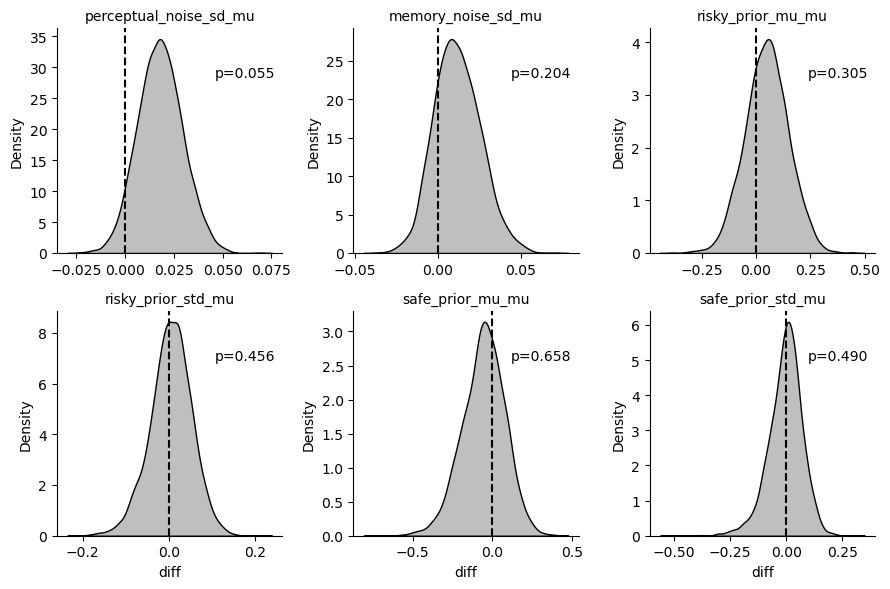

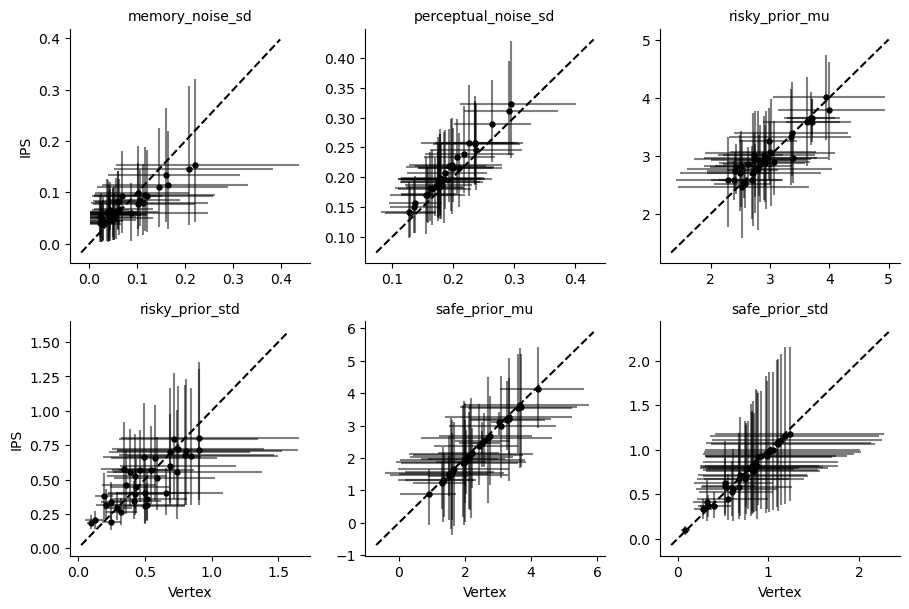

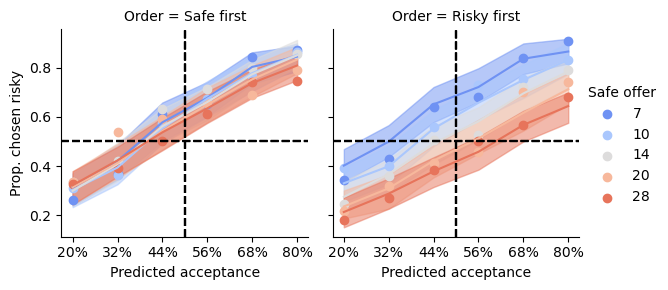

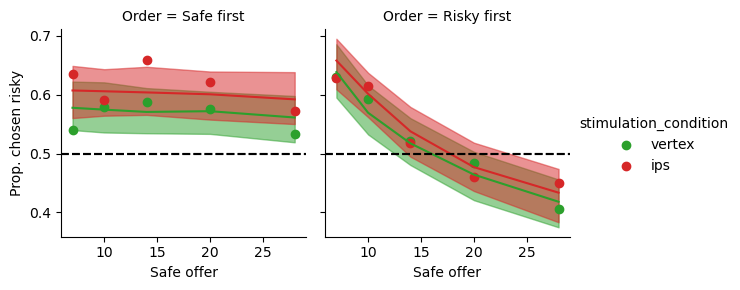

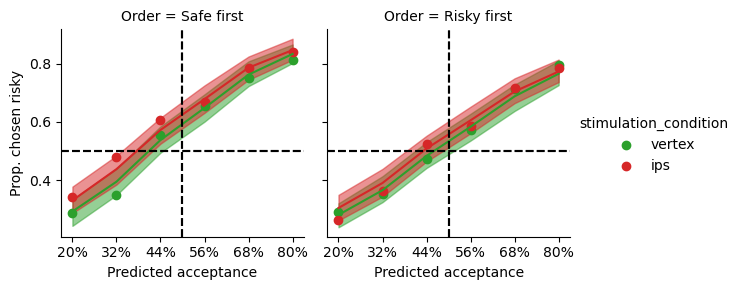

In [10]:
process_model('5')

# Model 5b

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
Sampling: [ll_bernoulli]


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

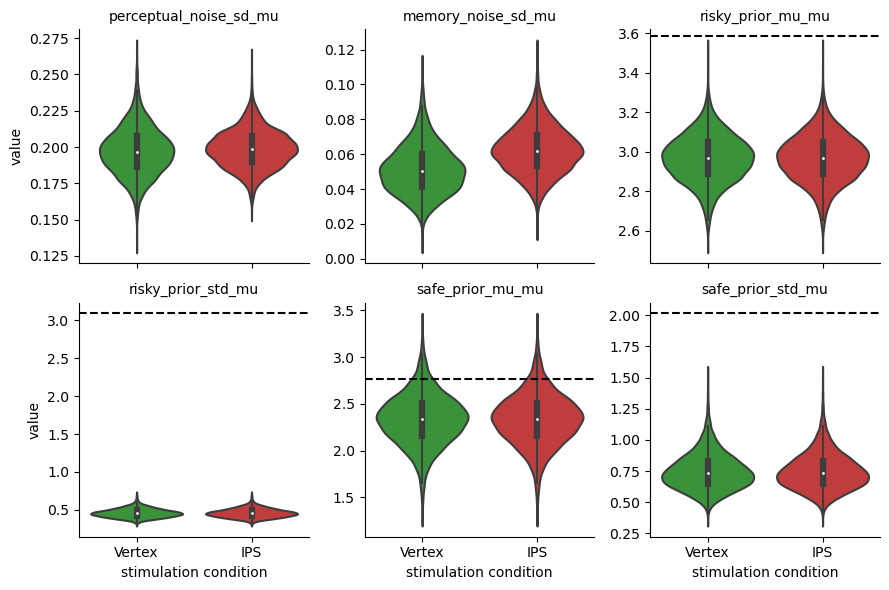

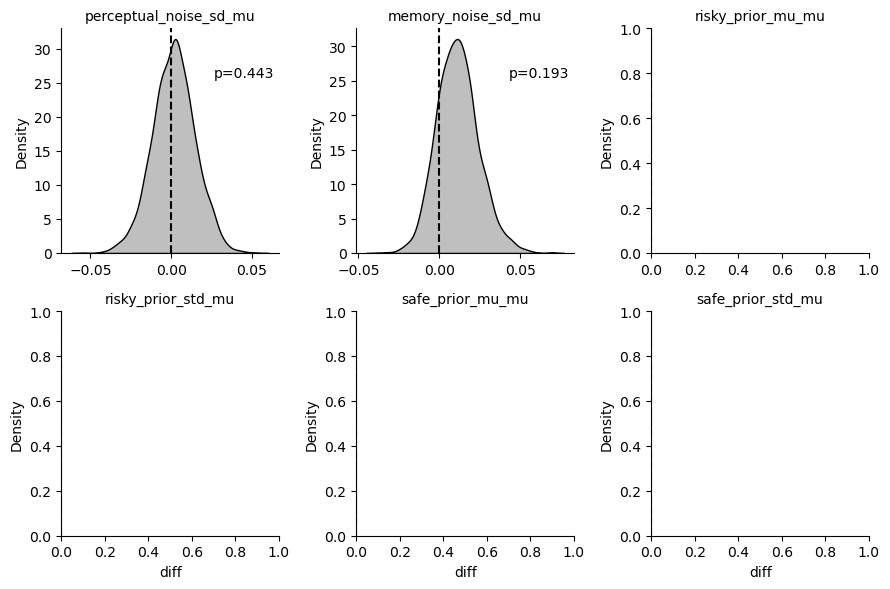

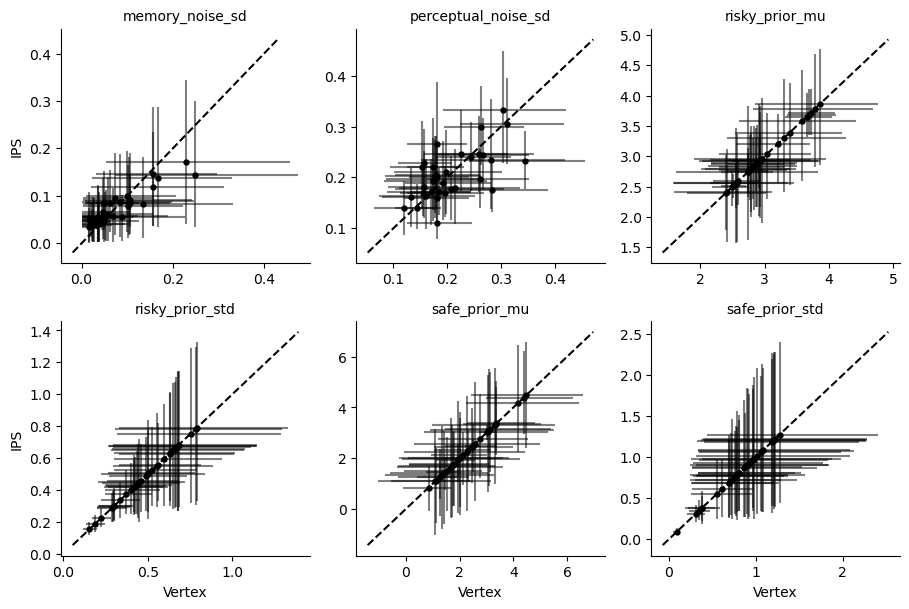

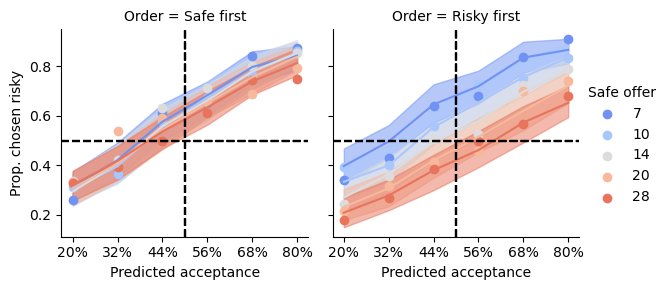

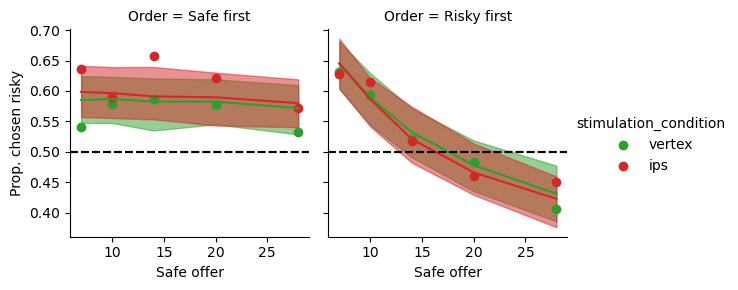

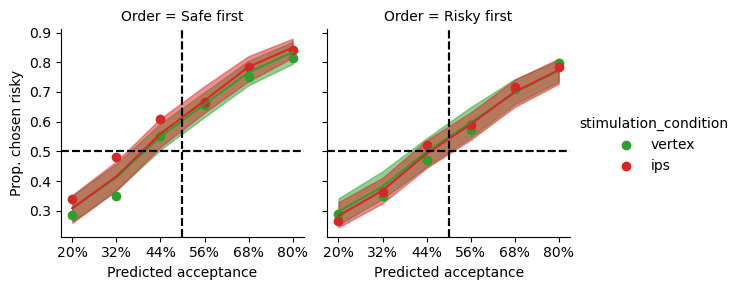

In [11]:
process_model('5b')

/Users/gdehol/git/tms_risk/tms_risk/utils/data.py:81: UserWarning: Subject 10/session 1 has only 5 runs!!
  warnings.warn('Subject 10/session 1 has only 5 runs!!')


Dropping the baseline condition
perceptual_noise_sd_mu
memory_noise_sd_mu
prior_mu_mu
prior_std_mu


/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/Users/gdehol/mambaforge/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)


perceptual_noise_sd
memory_noise_sd
prior_mu
prior_std


Sampling: [ll_bernoulli]


/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi = pd.DataFrame(az.hdi(ppc.T.values), index=ppc.index,
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:131: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ppc = ppc.groupby(['subject']+groupby).mean()
/Users/gdehol/git/tms_risk/tms_risk/cogmodels/utils.py:86: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future rel

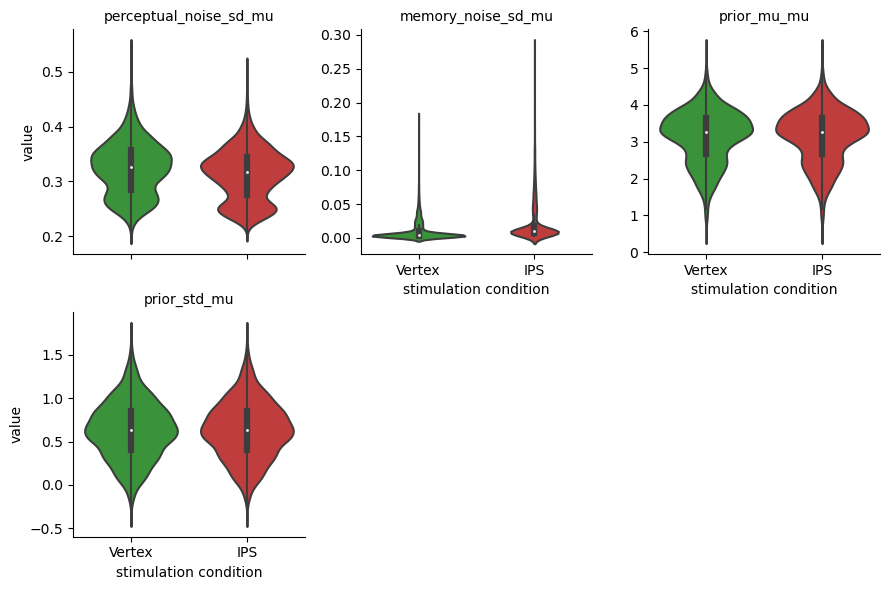

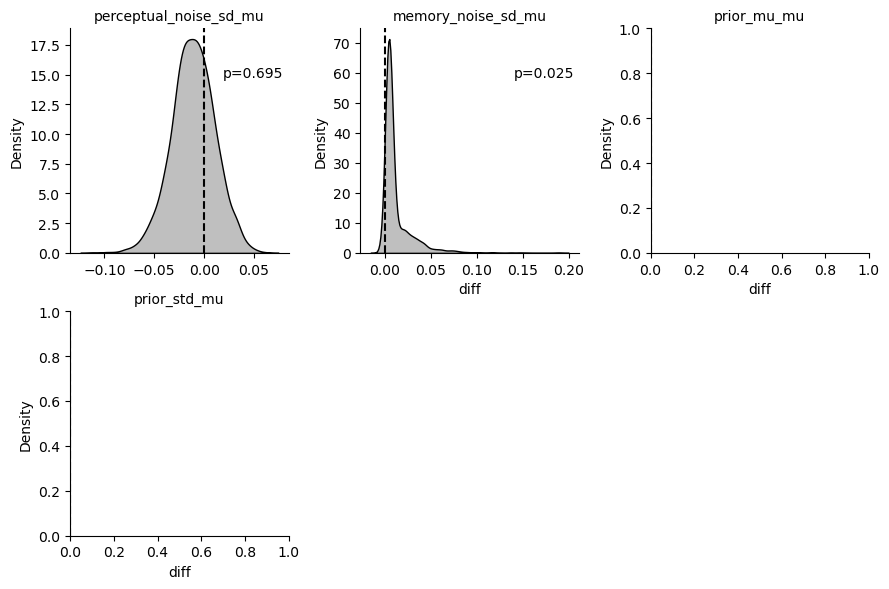

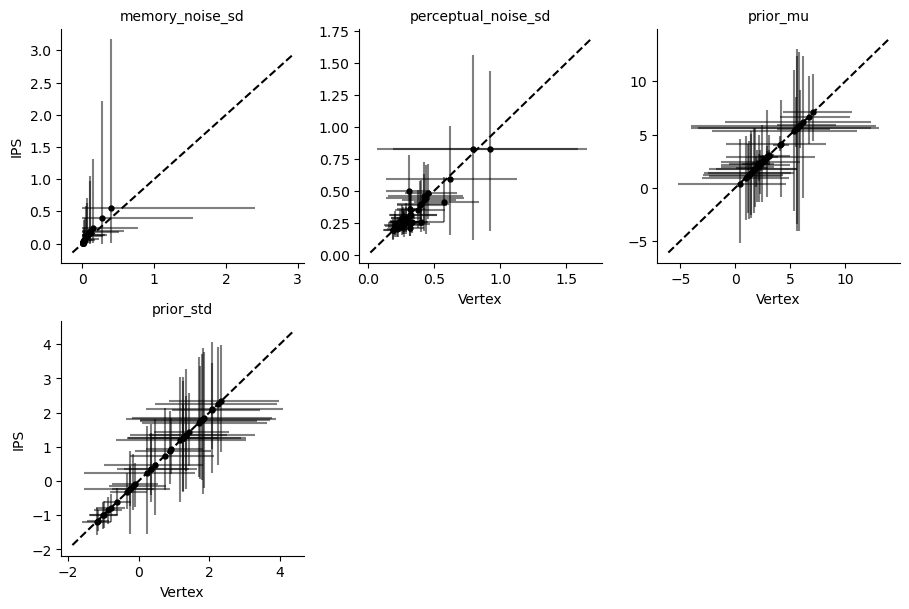

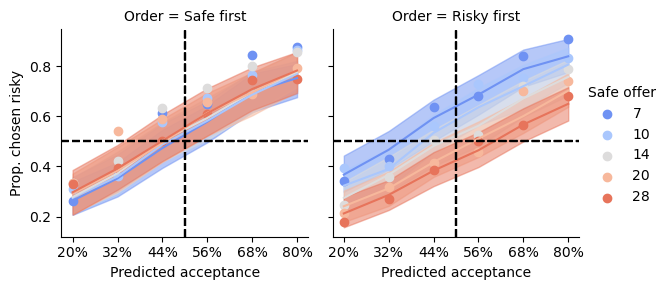

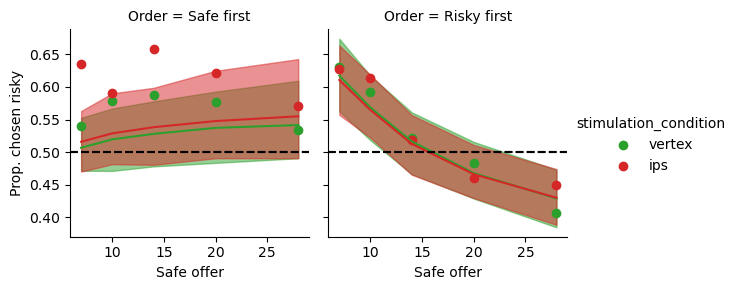

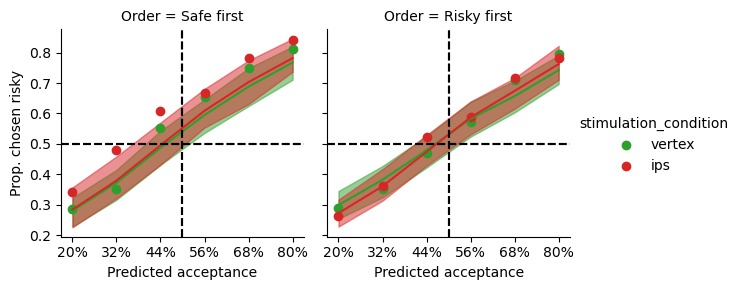

In [7]:
process_model('5c')